In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [7]:
# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# Reference date for tenure calculations (use current project date)
REFERENCE_DATE = pd.Timestamp("2025-10-14")  # adjust if you prefer


In [9]:
# ---------------------------------------------
# STEP 3: Generate Synthetic HR Dataset (5000 rows)
# ---------------------------------------------

n = 5000

# Basic personal/demographic fields
employee_id = np.arange(10000, 10000 + n)
age = np.random.randint(21, 61, size=n)
gender = np.random.choice(['Male', 'Female', 'Non-binary'], p=[0.65, 0.34, 0.01], size=n)

# Departments
departments = ['Sales', 'Research & Development', 'Human Resources', 'Finance', 'IT', 'Operations', 'Marketing']
dept_probs = [0.25, 0.35, 0.05, 0.07, 0.12, 0.12, 0.04]
department = np.random.choice(departments, p=dept_probs, size=n)

# Job roles by department
job_role = []
for d in department:
    if d == 'Sales':
        job_role.append(np.random.choice(['Sales Executive','Product Manager','Marketing Specialist'], p=[0.7,0.15,0.15]))
    elif d == 'Research & Development':
        job_role.append(np.random.choice(['Research Scientist','Laboratory Tech','Data Analyst'], p=[0.6,0.2,0.2]))
    elif d == 'Human Resources':
        job_role.append('HR Manager')
    elif d == 'Finance':
        job_role.append(np.random.choice(['Finance Manager','Product Manager'], p=[0.8,0.2]))
    elif d == 'IT':
        job_role.append(np.random.choice(['Software Engineer','Data Analyst','Product Manager'], p=[0.6,0.25,0.15]))
    elif d == 'Operations':
        job_role.append('Operations Manager')
    elif d == 'Marketing':
        job_role.append('Marketing Specialist')
job_role = np.array(job_role)

# Education and marital status
education_levels = ['Below College', 'College', 'Bachelor', 'Master', 'Doctor']
education = np.random.choice(education_levels, p=[0.05, 0.15, 0.5, 0.25, 0.05], size=n)
marital_status = np.random.choice(['Single', 'Married', 'Divorced'], p=[0.45,0.5,0.05], size=n)
education_field = np.random.choice(['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Other'], size=n)

 

In [10]:
# ---------------------------------------------
# STEP 4: Add Income and Experience Related Fields
# ---------------------------------------------

base_income_map = {
    'Sales Executive': 40000,
    'Research Scientist': 70000,
    'Laboratory Tech': 35000,
    'HR Manager': 55000,
    'Finance Manager': 80000,
    'Software Engineer': 90000,
    'Operations Manager': 60000,
    'Marketing Specialist': 50000,
    'Data Analyst': 65000,
    'Product Manager': 95000
}

monthly_income = np.array([int(base_income_map[j] * np.random.uniform(0.7, 1.6)) for j in job_role])

# Hire date and years at company
start = pd.Timestamp("2005-01-01")
end = pd.Timestamp("2025-09-30")
days_range = (end - start).days
hire_dates = [start + pd.Timedelta(days=int(x)) for x in np.random.rand(n) * days_range]
hire_date = pd.to_datetime(hire_dates)

years_at_company = ((REFERENCE_DATE - hire_date).days / 365).round(2)
years_at_company = np.clip(years_at_company, 0.0, 40.0)

total_working_years = np.maximum(years_at_company + np.random.randint(0, 11, size=n), 0).astype(int)
num_companies_worked = np.random.choice([1,2,3,4,5,6], p=[0.35,0.3,0.18,0.1,0.05,0.02], size=n)

 

In [11]:
# ---------------------------------------------
# STEP 5: Add Performance, Satisfaction & Engagement Fields
# ---------------------------------------------

performance_rating = np.random.choice([1,2,3,4,5], p=[0.03,0.12,0.5,0.28,0.07], size=n)
job_satisfaction = np.random.choice([1,2,3,4], p=[0.1,0.2,0.45,0.25], size=n)
environment_satisfaction = np.random.choice([1,2,3,4], p=[0.12,0.22,0.4,0.26], size=n)
work_life_balance = np.random.choice([1,2,3,4], p=[0.05,0.25,0.5,0.2], size=n)
training_times_last_year = np.clip(np.random.poisson(2, size=n), 0, 10)

overtime = np.random.choice(['Yes','No'], p=[0.22,0.78], size=n)
business_travel = np.random.choice(['Travel_Rarely','Travel_Frequently','Non-Travel'], p=[0.7,0.05,0.25], size=n)
 

In [12]:
# ---------------------------------------------
# STEP 6: Add Promotions, Distance & Other Features
# ---------------------------------------------

promotions = np.random.choice([0,1,2,3,4], p=[0.6,0.25,0.08,0.05,0.02], size=n)

last_promo_date = []
for hd, p in zip(hire_date, promotions):
    if p == 0:
        last_promo_date.append(pd.NaT)
    else:
        min_days = 365
        max_days = (REFERENCE_DATE - hd).days
        days_after = np.random.randint(min_days, max_days) if max_days > min_days else min_days
        last_promo_date.append(hd + pd.Timedelta(days=days_after))
last_promo_date = pd.to_datetime(last_promo_date)

percent_salary_hike = np.clip(np.random.normal(12, 4, size=n) + promotions * 3, 0, 50).round(1)
distance_from_home = np.random.choice(range(1,61), size=n)
leave_balance = np.random.randint(0, 31, size=n)
stock_option_level = np.random.choice([0,1,2,3], p=[0.6,0.18,0.15,0.07], size=n)

 

In [13]:
# ---------------------------------------------
# STEP 7: Model Attrition Probability
# ---------------------------------------------

p_base = 0.08
p_attrition = (
    p_base
    + (3 - job_satisfaction) * 0.06
    + (overtime == 'Yes') * 0.05
    + (performance_rating == 1) * 0.05
    - (promotions > 0) * 0.02
    + (years_at_company < 1.0) * 0.04
    + (monthly_income < np.percentile(monthly_income, 25)) * 0.02
)
p_attrition = np.clip(p_attrition, 0.01, 0.9)
attrition = np.where(np.random.binomial(1, p_attrition).astype(int) == 1, 'Yes', 'No')

 

In [14]:
# ---------------------------------------------
# STEP 8: Combine Everything into a DataFrame
# ---------------------------------------------

df = pd.DataFrame({
    'EmployeeID': employee_id,
    'Age': age,
    'Gender': gender,
    'Department': department,
    'JobRole': job_role,
    'Education': education,
    'EducationField': education_field,
    'MaritalStatus': marital_status,
    'HireDate': hire_date,
    'YearsAtCompany': years_at_company,
    'TotalWorkingYears': total_working_years,
    'NumCompaniesWorked': num_companies_worked,
    'MonthlyIncome': monthly_income,
    'PercentSalaryHike': percent_salary_hike,
    'PerformanceRating': performance_rating,
    'JobSatisfaction': job_satisfaction,
    'EnvironmentSatisfaction': environment_satisfaction,
    'WorkLifeBalance': work_life_balance,
    'TrainingTimesLastYear': training_times_last_year,
    'OverTime': overtime,
    'BusinessTravel': business_travel,
    'Promotions': promotions,
    'LastPromotionDate': last_promo_date,
    'DistanceFromHome': distance_from_home,
    'LeaveBalance': leave_balance,
    'StockOptionLevel': stock_option_level,
    'Attrition': attrition
})

# Assign random managers
managers = np.random.choice(employee_id, size=int(n/10))
df['ManagerID'] = np.random.choice(managers, size=n)

# Introduce missing values
df.loc[np.random.choice(df.index, size=int(0.01*n), replace=False), 'EducationField'] = np.nan
df.loc[np.random.choice(df.index, size=int(0.02*n), replace=False), 'LastPromotionDate'] = pd.NaT

df.to_csv('hr_synthetic_5000.csv', index=False)
print("Dataset saved as hr_synthetic_5000.csv")
df.head()

 

Dataset saved as hr_synthetic_5000.csv


,EmployeeID,Age,Gender,Department,JobRole,Education,EducationField,MaritalStatus,HireDate,YearsAtCompany,...,TrainingTimesLastYear,OverTime,BusinessTravel,Promotions,LastPromotionDate,DistanceFromHome,LeaveBalance,StockOptionLevel,Attrition,ManagerID
0,10000,41,Female,Operations,Operations Manager,Bachelor,Other,Married,2021-08-19,4.16,...,2,No,Travel_Rarely,0,NaT,2,11,0,No,13106
1,10001,54,Female,Marketing,Marketing Specialist,Below College,Marketing,Single,2024-04-19,1.49,...,2,No,Travel_Frequently,0,NaT,40,7,0,No,10266
2,10002,49,Male,Operations,Operations Manager,Bachelor,Medical,Single,2021-11-02,3.95,...,4,No,Travel_Rarely,0,NaT,51,12,0,No,11596
3,10003,30,Male,Sales,Sales Executive,Bachelor,Other,Married,2009-08-11,16.19,...,2,Yes,Non-Travel,0,NaT,21,12,0,Yes,10741
4,10004,48,Male,Research & Development,Laboratory Tech,Bachelor,Technical Degree,Married,2025-07-31,0.21,...,4,No,Travel_Rarely,3,2026-07-31,52,30,2,Yes,12214


In [15]:
data=pd.read_csv("hr_synthetic_5000.csv")

In [16]:
data.head()

,EmployeeID,Age,Gender,Department,JobRole,Education,EducationField,MaritalStatus,HireDate,YearsAtCompany,...,TrainingTimesLastYear,OverTime,BusinessTravel,Promotions,LastPromotionDate,DistanceFromHome,LeaveBalance,StockOptionLevel,Attrition,ManagerID
0,10000,41,Female,Operations,Operations Manager,Bachelor,Other,Married,2021-08-19,4.16,...,2,No,Travel_Rarely,0,NaN,2,11,0,No,13106
1,10001,54,Female,Marketing,Marketing Specialist,Below College,Marketing,Single,2024-04-19,1.49,...,2,No,Travel_Frequently,0,NaN,40,7,0,No,10266
2,10002,49,Male,Operations,Operations Manager,Bachelor,Medical,Single,2021-11-02,3.95,...,4,No,Travel_Rarely,0,NaN,51,12,0,No,11596
3,10003,30,Male,Sales,Sales Executive,Bachelor,Other,Married,2009-08-11,16.19,...,2,Yes,Non-Travel,0,NaN,21,12,0,Yes,10741
4,10004,48,Male,Research & Development,Laboratory Tech,Bachelor,Technical Degree,Married,2025-07-31,0.21,...,4,No,Travel_Rarely,3,2026-07-31,52,30,2,Yes,12214


In [17]:
# ---------------------------------------------
# STEP 9: Basic EDA Overview
# ---------------------------------------------

print("Shape:", df.shape)
print("\nMissing values:")
print(df.isna().sum())

df.describe(include='all').T.head(10)
 

Shape: (5000, 28)

Missing values:
EmployeeID                    0
Age                           0
Gender                        0
Department                    0
JobRole                       0
Education                     0
EducationField               50
MaritalStatus                 0
HireDate                      0
YearsAtCompany                0
TotalWorkingYears             0
NumCompaniesWorked            0
MonthlyIncome                 0
PercentSalaryHike             0
PerformanceRating             0
JobSatisfaction               0
EnvironmentSatisfaction       0
WorkLifeBalance               0
TrainingTimesLastYear         0
OverTime                      0
BusinessTravel                0
Promotions                    0
LastPromotionDate          3048
DistanceFromHome              0
LeaveBalance                  0
StockOptionLevel              0
Attrition                     0
ManagerID                     0
dtype: int64


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
EmployeeID,5000.0,NaN,NaN,NaN,12499.5,10000.0,11249.75,12499.5,13749.25,14999.0,1443.520003
Age,5000.0,NaN,NaN,NaN,40.1534,21.0,30.0,40.0,50.0,60.0,11.471835
Gender,5000,3,Male,3224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department,5000,7,Research & Development,1744,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JobRole,5000,10,Research Scientist,1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education,5000,5,Bachelor,2520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationField,4950,5,Technical Degree,1026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,5000,3,Married,2529,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HireDate,5000,NaN,NaN,NaN,2015-07-08 08:11:54.240000256,2005-01-01 00:00:00,2010-05-18 18:00:00,2015-07-22 00:00:00,2020-09-23 00:00:00,2025-09-28 00:00:00,NaN
YearsAtCompany,5000.0,NaN,NaN,NaN,10.27581,0.04,5.06,10.24,15.42,20.8,5.953934


C:\Users\LCC\AppData\Local\Temp\ipykernel_9028\1627134162.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Attrition', palette='pastel')


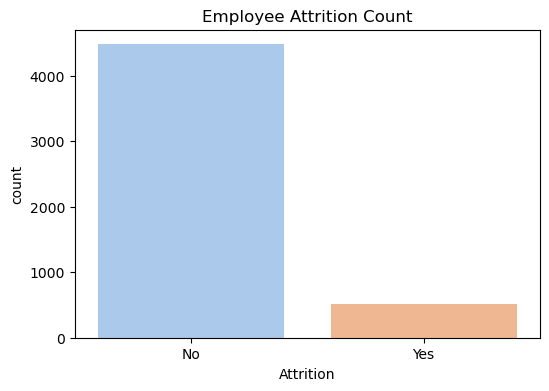

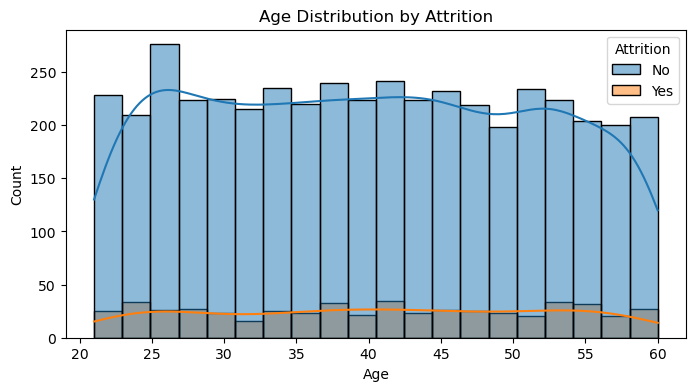

In [20]:
# ---------------------------------------------
# STEP 10: Visual EDA
# ---------------------------------------------
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Attrition', palette='pastel')
plt.title('Employee Attrition Count')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data=df, x='Age', hue='Attrition', bins=20, kde=True)
plt.title('Age Distribution by Attrition')
plt.show()

 

C:\Users\LCC\AppData\Local\Temp\ipykernel_9028\4293676957.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Department', y='MonthlyIncome', ci=None, palette='viridis')
C:\Users\LCC\AppData\Local\Temp\ipykernel_9028\4293676957.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Department', y='MonthlyIncome', ci=None, palette='viridis')


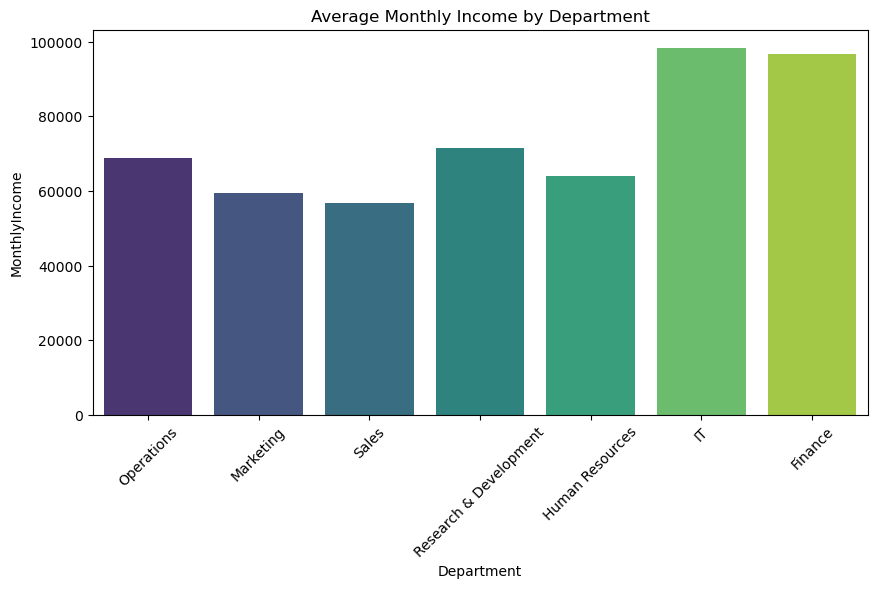

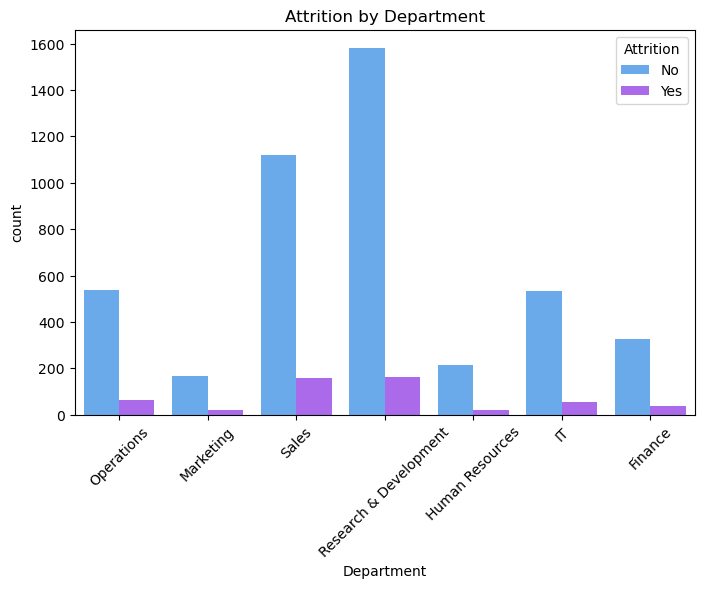

In [21]:
# ---------------------------------------------
# STEP 11: Department and Salary Insights
# ---------------------------------------------

plt.figure(figsize=(10,5))
sns.barplot(data=df, x='Department', y='MonthlyIncome', ci=None, palette='viridis')
plt.title('Average Monthly Income by Department')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Department', hue='Attrition', palette='cool')
plt.title('Attrition by Department')
plt.xticks(rotation=45)
plt.show()
 

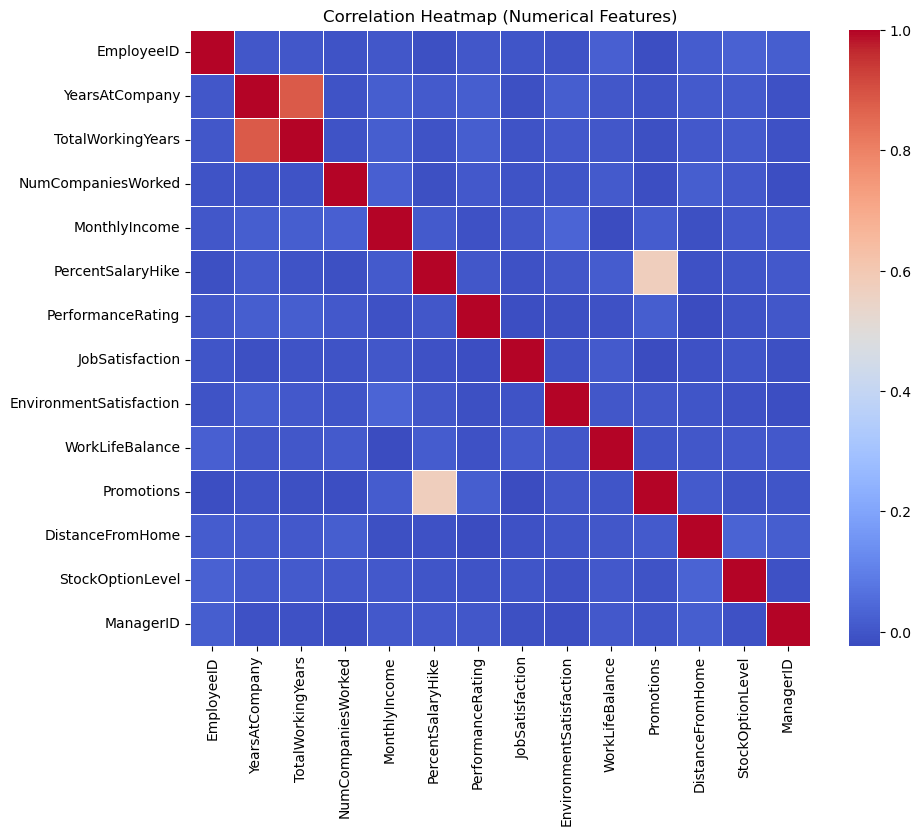

In [22]:
# ---------------------------------------------
# STEP 12: Correlation Analysis
# ---------------------------------------------

num_df = df.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()
 